In [48]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path(os.getcwd()).parent)
print(Path().cwd())

/Users/samantha/QuantUS-Plugins-CEUS
/Users/samantha


## Select Contrast-Enhanced Ultrasound (CEUS) Cine and Parser

In [49]:
from src.image_loading.options import get_scan_loaders

print("Available scan loaders:", list(get_scan_loaders().keys()))

Available scan loaders: ['avi', 'nifti', 'custom_dicom', 'mp4']


In [50]:
scan_type = 'avi'

scan_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/p5/p5 pre/Patient #5 pre (MJL) inj1 Original Loop.avi.avi'
scan_loader_kwargs = {
    'transpose': False
}

In [51]:
from src.entrypoints import scan_loading_step

image_data = scan_loading_step(scan_type, scan_path, **scan_loader_kwargs)

(684, 960, 1280, 3)
(684, 960, 1280)


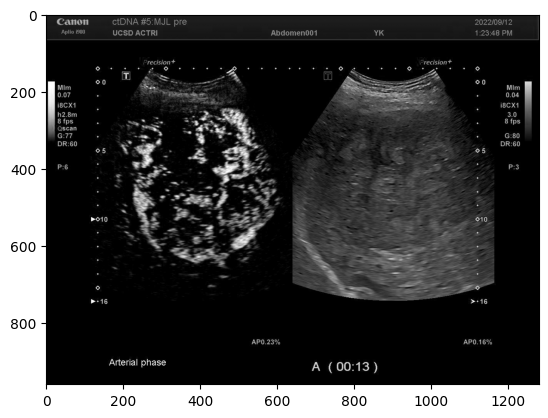

In [52]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

single_image = image_data.pixel_data[100,:,:,0]
plt.imshow(single_image,cmap='gray')
print(image_data.pixel_data.shape)

# Reshape the data and store into the image_data
temp = image_data.pixel_data[:,:,:,0]
# temp = np.transpose(single_video,(2,1,0))
image_data.pixel_data = temp
print(image_data.pixel_data.shape)

## Load Segmentation

Assumes same segmentation for each frame

In [53]:
from src.seg_loading.options import get_seg_loaders

print("Available segmentation loaders:", list(get_seg_loaders().keys()))

Available segmentation loaders: ['nifti', 'load_bolus_mask']


In [54]:
seg_type = 'nifti'

seg_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/p5/p5 pre/p5_pre_roi.nii.gz'
seg_loader_kwargs = {}

In [55]:
from src.entrypoints import seg_loading_step

seg_data = seg_loading_step(seg_type, image_data, seg_path, scan_path, **seg_loader_kwargs)

In [56]:

print(seg_data.seg_mask.shape)

(960, 1280)


In [57]:
# # Use inline backend - MORE RELIABLE for Jupyter
# %matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.ndimage import binary_erosion
# from IPython.display import clear_output
# import time
# def get_mask_boundary(mask_slice):
#     """Extract boundary of a binary mask using erosion."""
#     if mask_slice.max() == 0:
#         return np.zeros_like(mask_slice, dtype=bool)
#     eroded = binary_erosion(mask_slice)
#     boundary = mask_slice.astype(bool) & ~eroded
#     return boundary
# print(f"Image shape: {image_data.pixel_data.shape}")
# print(f"Mask shape: {seg_data.seg_mask.shape}")

# # Frame range
# num_frames = image_data.pixel_data.shape[-1]
# start_frame = 0
# end_frame = min(num_frames, 300)
# print(f"Visualizing frames {start_frame} to {end_frame}")
# print("Starting animation...\n")
# # Loop through frames
# for frame in range(start_frame, end_frame):
#     # Clear previous output and display current frame
#     clear_output(wait=True)
#     # Create figure for this frame
#     fig, axes = plt.subplots(figsize=(18, 6))
#     # === AXIAL VIEW ===
#     axial_img = np.transpose(image_data.pixel_data[frame, :,  :])
#     axial_mask = np.transpose(seg_data.seg_mask)
#     axial_boundary = get_mask_boundary(axial_mask)
#     axes.imshow(axial_img, cmap='gray')
#     axes.contour(axial_boundary, colors='red', linewidths=2)
#     axes.set_xlabel('Lateral (X)')
#     axes.set_ylabel('Depth (Y)')
    
#     # Add overall frame counter
#     fig.suptitle(f'Frame {frame}/{end_frame-1}', fontsize=16, fontweight='bold')
#     plt.tight_layout()
#     plt.show()
#     # Print progress
#     print(f"Frame {frame}/{end_frame-1}")
#     # Pause
#     time.sleep(0.01)
#     # Close figure to save memory
#     plt.close(fig)
# print("\nAnimation complete!")

In [58]:
# %matplotlib inline
# import numpy as np
# from IPython.display import clear_output
# import time
# print(seg_data.seg_mask.shape)

# for i in range(50):
#     clear_output(wait = True)
#     mask_image = seg_data.seg_mask

#     plt.imshow(np.transpose(mask_image),cmap='gray')
#     plt.show()
#     time.sleep(0.1)


## CEUS Quantitative Temporal Curve Analysis

In [59]:
from src.time_series_analysis.options import get_analysis_types, get_required_kwargs

all_analysis_types, all_analysis_funcs = get_analysis_types()
print("Available analysis types:", list(all_analysis_types.keys()))
print("Available analysis functions:", list(all_analysis_funcs.keys()))

Available analysis types: ['curves_paramap', 'curves']
Available analysis functions: ['pyradiomics', 'tic']


In [60]:
analysis_type = 'curves_paramap'
analysis_funcs = ['tic']

# Find all required kwargs for the analysis functions
analysis_funcs = analysis_funcs if len(analysis_funcs) else list(all_analysis_funcs[analysis_type].keys())
required_kwargs = get_required_kwargs(analysis_type, analysis_funcs)
print("Required kwargs for current analysis:", required_kwargs)

Required kwargs for current analysis: ['ax_vox_len', 'cor_vox_len', 'ax_vox_ovrlp', 'sag_vox_len', 'sag_vox_ovrlp', 'cor_vox_ovrlp']


In [61]:
analysis_kwargs = {
    'ax_vox_ovrlp': 50,  # %
    'sag_vox_ovrlp': 50,  # %
    'cor_vox_ovrlp': 50,  # %
    'ax_vox_len': 100.0,  # mm
    'sag_vox_len': 100.0,  # mm
    'cor_vox_len': 100.0,  # mm
    'curves_output_path': '', # don't export the curves we generate
}

In [62]:
from src.entrypoints import analysis_step

analysis_obj = analysis_step(analysis_type, image_data, seg_data, analysis_funcs, **analysis_kwargs)

Computing curves: 100%|██████████| 684/684 [01:13<00:00,  9.32it/s]


In [63]:
# import matplotlib.pyplot as plt
# # Create a figure with a specific size (e.g., 8 inches wide, 6 inches tall)
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.scatter(analysis_obj.time_arr,analysis_obj.curves[0]['TIC'], label='Motion Compensated', s = 10)
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('TIC')
# ax.set_title('TIC Over Time')
# ax.legend()
# plt.show()

## Curve Quantification

In [64]:
from src.curve_quantification.options import get_quantification_funcs

quantification_funcs = get_quantification_funcs()
print("Available quantification functions:", quantification_funcs.keys())

Available quantification functions: dict_keys(['auc_no_fit', 'cmus_firstorder', 'dte', 'first_order_full', 'first_order_select', 'lognormal_fit_full', 'lognormal_fit_select', 'wash_rates'])


In [65]:
function_names = ['lognormal_fit_full'] # Empty list will use all functions
output_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/p5/p5 pre/mc_paramap'
output_path += "/curve.csv"
curve_quantifications_kwargs = {
    'curves_to_fit': ['TIC'],
}

In [47]:
from src.entrypoints import curve_quantification_step

curve_quant = curve_quantification_step(analysis_obj, function_names, output_path, **curve_quantifications_kwargs)

['lognormal_fit_full']
Ordered functions: ['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
Error fitting curve: operands could not be broadcast together with shapes (684,) (1368,) 
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']


IndexError: index 799 is out of bounds for axis 0 with size 684

## Parametric Map Visualizations

In [ ]:
from src.visualizations.options import get_visualization_types

types, funcs = get_visualization_types()
print("Available visualization types:", list(types.keys()))
print("Available visualization functions:", list(funcs.keys()))

Available visualization types: ['paramap']
Available visualization functions: ['paramap']


In [ ]:
vis_type = 'paramap'
params = [] # Empty list will use all parameters 
vis_funcs = []
vis_kwargs = {
    'paramap_folder_path': '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/p16/p16 wk 24/overlap_paramap_bigroi_10',
    'hide_all_visualizations': False,  # Set to True to hide all visualizations
}

In [ ]:
from src.entrypoints import visualization_step

vis_obj = visualization_step(curve_quant, vis_type, params, vis_funcs, **vis_kwargs)